In [ ]:
# Imports que necesitaremos a lo largo del proyecto
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from google.colab import files
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard,LearningRateScheduler
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import Xception, MobileNetV2

In [ ]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102969 sha256=47b80f6515ac7e0b411e12b893ee4508444e41adb75af361a006f0bef255782f
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


## Carga del conjunto de datos

In [ ]:
def cargar_dataset():
  # Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
  files.upload()

  # Creamos un directorio en el que copiamos el fichero kaggle.json
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Descargamos el dataset
  !kaggle datasets download -d gpiosenka/100-bird-species

  # Creemos un directorio para descomprimir los datos
  !mkdir birds_dataset

  # Descomprimimos los datos y los dejamos listos para trabajar
  !unzip -o 100-bird-species.zip -d birds_dataset | awk 'BEGIN {ORS=" "} {if(NR%500==0)print "."}'

def crear_basefolder():
  # Conectamos con nuestro Google Drive
  drive.mount('/content/drive')

  # Establezco una ruta absoluta a un directorio existente de mi Google Drive
  BASE_FOLDER = "/content/drive/MyDrive/MasterIA/07MIAR_Redes-neuronales-y-deep-learning/"

  return BASE_FOLDER

In [ ]:
BASE_FOLDER = crear_basefolder()
cargar_dataset()

Mounted at /content/drive


Saving kaggle.json to kaggle.json
 99% 1.94G/1.96G [00:12<00:00, 263MB/s]
100% 1.96G/1.96G [00:12<00:00, 173MB/s]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## Inspección del dataset

### Observación de las imágenes del dataset

Este código se utiliza para obtener una imagen aleatoria del conjunto de entrenamiento de un dataset de aves.

- Primero, define la ruta base donde se encuentran las carpetas de clases de imágenes de entrenamiento.
- Luego, utiliza `os.scandir()` para escanear esta ruta y obtener una lista de todas las carpetas de clases.
- La función `get_random_image()` elige aleatoriamente una de estas carpetas.
- Dentro de la carpeta seleccionada, selecciona una imagen al azar.
- Devuelve la imagen seleccionada y su etiqueta correspondiente.

Esta función es útil para obtener muestras aleatorias del conjunto de datos de entrenamiento, lo que puede ser útil para visualización o análisis de datos.

In [ ]:
# Ruta base para mostrar imagenes de muestra del conjunto de entrenamiento
path = 'birds_dataset/train/'
folders = [f for f in os.scandir(path) if f.is_dir()]
def get_random_image(folders):
   # Elegimos una carpeta aleatoriamente
    folder = np.random.choice(folders)

    # Dentro de la carpeta elegida, seleccionamos una imagen también de manera aleatoria
    images = [nombre for nombre in os.listdir(folder)]
    image = np.random.choice(images)
    img_path = os.path.join(folder, image)
    label = folder.name

    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, label

Este código crea una cuadrícula de subgráficos de 3x3 utilizando Matplotlib. Para cada subgráfico en la cuadrícula, selecciona aleatoriamente una imagen del conjunto de entrenamiento y la muestra en el subgráfico correspondiente. Además, establece el título de cada subgráfico como la etiqueta de la imagen. El resultado es una visualización de 9 imágenes aleatorias con sus etiquetas en una cuadrícula de 3x3.

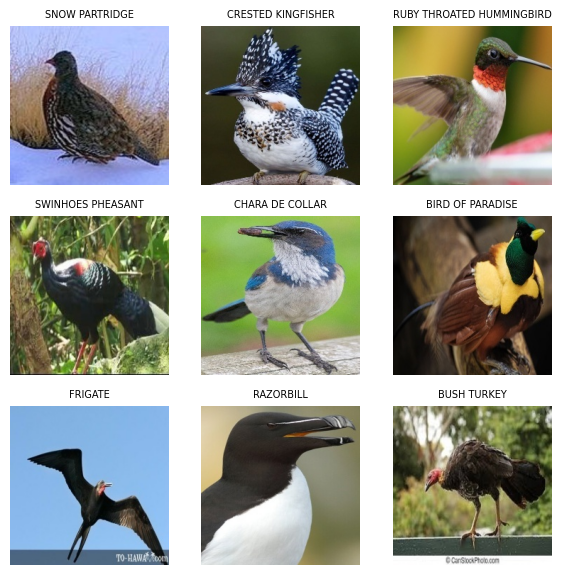

In [ ]:
f, axarr = plt.subplots(3,3, figsize=(7, 7))
for x in range(3):
  for y in range(3):
    img, label = get_random_image(folders)
    plt.imshow(img)
    axarr[x,y].imshow(img)
    axarr[x, y].axis('off')
    axarr[x, y].set_title(label, fontsize=7)

### Características de las imágenes del dataset

Si observamos el número de imágenes por especie, podemos ver que las clases no están equitativamente distribuídas. Por lo tanto, para valorar el modelo debemos tener en cuenta otras medidas a parte de la precisión como el F1 score.

In [ ]:
num_images_per_folder = np.array([len([i for i in os.listdir(f)]) for f in folders])
print(f"Especie con más imágenes ({num_images_per_folder.max()}): {folders[np.argmax(num_images_per_folder)].name}")
print(f"Especie con menos imágenes ({num_images_per_folder.min()}): {folders[np.argmin(num_images_per_folder)].name}")
print()
print(f'Media de imágenes por carpeta: {num_images_per_folder.mean()}')

Especie con más imágenes (263): RUFOUS TREPE
Especie con menos imágenes (130): RED TAILED THRUSH

Media de imágenes por carpeta: 161.2095238095238


En la página del dataset se informa que todas las imágenes tienen un tamaño de 224x224 píxeles. Sin embargo, vamos a comprobar si es cierto.

In [ ]:
images_with_diff_res=[]
for f in folders:
  images = [nombre for nombre in os.listdir(f)]
  for i in images:
    img_path = os.path.join(f, i)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    np_img = np.array(img)
    shape = np_img.shape
    if(shape[0] != 224 or shape[1] != 224):
      images_with_diff_res.append([f, i])

In [ ]:
print(f"Número de imágenes con distinta resolución: {len(images_with_diff_res)}")
print("Algunos ejemplos de resoluciones diferentes:")
for f, i in images_with_diff_res[:5]:
  img_path = os.path.join(f, i)
  img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
  np_img = np.array(img)
  shape = np_img.shape
  print(shape)

Número de imágenes con distinta resolución: 201
Algunos ejemplos de resoluciones diferentes:
(196, 170, 3)
(149, 146, 3)
(915, 507, 3)
(117, 223, 3)
(168, 243, 3)


Podemos observar que realmente muchas de las imágenes no tienen una resolución de 224x224 píxeles, por lo que será necesario realizar un reescalado de estas. En la página del dataset se recomienda reescalar las imágenes a 150x150 píxeles debido al tamaño del dataset.

# Funciones auxiliares

In [ ]:
# Funcion para representar las curvas de precision y error
# en entrenamiento y validacion
def plot_model_loss_acc(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(12, 6))

    # Obtener el número total de épocas y el máximo valor de pérdida
    epochs = range(1, len(history.history["loss"]) + 1)
    max_loss = max(max(history.history["loss"]), max(history.history["val_loss"]))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], label="train_loss")
    plt.plot(epochs, history.history["val_loss"], label="val_loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, max_loss * 1.1)  # Ajustar el rango del eje y
    plt.legend()

    # Gráfica de precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], label="train_acc")
    plt.plot(epochs, history.history["val_accuracy"], label="val_acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)  # La precisión está en el rango [0, 1]
    plt.legend()

    plt.tight_layout()
    plt.show()

# RED FROM SCRATCH

---
- **Cargar Conjuntos de Datos de Imágenes**

En este bloque de código, se definen funciones para cargar conjuntos de datos de imágenes desde directorios. Estas funciones son útiles para cargar conjuntos de entrenamiento, validación y prueba en proyectos de aprendizaje profundo.

- **Directorios de Datos:**
  - `train_path`: Ruta al directorio que contiene las imágenes de entrenamiento.
  - `val_path`: Ruta al directorio que contiene las imágenes de validación.
  - `test_path`: Ruta al directorio que contiene las imágenes de prueba.

- **Funciones:**
  1. `load_datasets_train(train_path, h=150, w=150)`: Carga el conjunto de datos de entrenamiento desde `train_path` con la altura y anchura especificadas (predeterminado: 150x150).
  2. `load_datasets_val(val_path, h=150, w=150)`: Carga el conjunto de datos de validación desde `val_path` con la altura y anchura especificadas (predeterminado: 150x150).
  3. `load_datasets_test(test_path, h=150, w=150)`: Carga el conjunto de datos de prueba desde `test_path` con la altura y anchura especificadas (predeterminado: 150x150).

- **Argumentos Opcionales:**
  - `h`: Altura deseada de las imágenes.
  - `w`: Anchura deseada de las imágenes.

Para cada función, se especifica la ruta al directorio de datos, la semilla para la aleatorización, el modo de etiquetado (categórico en este caso) y el tamaño de la imagen. Estos conjuntos de datos cargados pueden ser utilizados posteriormente para entrenar y evaluar los métodos de aprendizaje profundo.

---

In [ ]:
train_path = 'birds_dataset/train'
val_path = 'birds_dataset/valid'
test_path = 'birds_dataset/test'

TARGET_SIZE = (150,150)

def load_datasets_train(train_path, h=150, w=150):
  # Train dataset
  train_ds = image_dataset_from_directory(
      train_path,
      seed=42,
      shuffle=True,
      label_mode='categorical',
      image_size=(h, w))
  return train_ds

def load_datasets_val(val_path, h=150, w=150):
  # Validation dataset
  val_ds = image_dataset_from_directory(
    val_path,
    seed=42,
    shuffle=False,
    label_mode='categorical',
    image_size=(h, w))
  return val_ds

def load_datasets_test(train_path, h=150, w=150):
  # Test dataset
  test_ds = image_dataset_from_directory(
      test_path,
      seed=42,
      shuffle=False,
      label_mode='categorical',
      image_size=(h, w))
  return test_ds

def evaluate_entire_dataset(model, test_dataset):
  batch_losses = []
  batch_accuracies = []

  for i in range(len(test_data)):
      x_batch, y_batch = next(test_data)
      result = model.evaluate(x_batch, y_batch, verbose=0)

      batch_losses.append(result[0])
      batch_accuracies.append(result[1])
  average_loss = sum(batch_losses) / len(batch_losses)
  average_accuracy = sum(batch_accuracies) / len(batch_accuracies)
  return average_loss, average_accuracy

---
**Configuración de Entrenamiento**

En este bloque de código se definen algunas configuraciones y estrategias para entrenar modelos de redes neuronales utilizando la biblioteca Keras.

- **Early Stopping:**
  - Se configura la estrategia de detención anticipada del entrenamiento (early stopping).
    - El monitor observa la pérdida en el conjunto de validación.
    - La paciencia establece el número de épocas sin mejoras permitidas.
    - Se restauran los mejores pesos del modelo cuando se detiene el entrenamiento.

Este bloque de código establece las configuraciones necesarias y define una estrategia de detención anticipada para evitar el sobreajuste durante el entrenamiento.

---

In [ ]:
# Early stopping usando el accuracy de la validación
earlystop = EarlyStopping(
    monitor='val_loss',   # Monitorizamos la precisión en el conjunto de validación
    patience=5,               # Número de épocas sin mejora permitidas
    restore_best_weights=True # Restaurar los mejores pesos del modelo
)

---
**Red Neuronal Convolucional para Clasificación de Imágenes**

En este bloque de código se define una red neuronal convolucional (CNN) para la clasificación de imágenes utilizando la biblioteca Keras. La red consta de dos partes principales: una red neuronal base convolucional y un modelo de clasificación final (top model).

- **Definición de Variables:**
  - `input_shape`: Forma de entrada de las imágenes (alto, ancho, canales).
  - `filters`: Número de filtros convolucionales en cada capa convolucional.
  - `kernel_size`: Tamaño del kernel de convolución.
  - `pool_size`: Tamaño de la ventana de agrupación máxima.
  - `base_dropout_rate`: Tasa de abandono (dropout) para las capas de la red neuronal base.
  - `dense_units`: Número de unidades en las capas densas del modelo de clasificación final.
  - `num_classes`: Número de clases de salida para la clasificación.
  - `classification_learning_rate`: Tasa de aprendizaje para el optimizador Adam en el modelo de clasificación.
  - `classification_dropout_rate`: Tasa de abandono (dropout) para las capas densas del modelo de clasificación final.

- **Definición de Capas:**
  - Se definen las capas de convolución, normalización y agrupación máxima para la red neuronal base.
  - Después de cada capa de convolución, se aplica normalización por lotes y se utiliza la función de activación ReLU.
  - Se añaden capas de abandono (dropout) para regularización después de cada capa de agrupación máxima.
  - Finalmente, se aplanan los datos y se agregan capas densas para la clasificación final.

- **Compilación del Modelo:**
  - Se compila el modelo utilizando el optimizador Adam con la tasa de aprendizaje especificada.
  - La función de pérdida utilizada es la entropía cruzada categórica, adecuada para problemas de clasificación multiclase.
  - Se monitorea la precisión (accuracy) durante el entrenamiento.

Este bloque de código define una arquitectura de red neuronal convolucional para la clasificación de imágenes. La red base convolucional extrae características relevantes de las imágenes, mientras que el modelo de clasificación final realiza la clasificación en las clases de interés.

---

In [ ]:
# Definición de variables para la red neuronal base
input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
filters = 64
kernel_size = (3, 3)
pool_size = (2, 2)
base_dropout_rate = 0.5

# Definición de variables para el modelo de clasificación final (top model)
dense_units = [2048, 1024]
num_classes = 525
classification_learning_rate = 0.001  # Ajusta la tasa de aprendizaje para Adam
classification_dropout_rate = 0.5

# Definición de capas de la red neuronal base
inputs = keras.Input(shape=input_shape)
conv1 = Conv2D(filters, kernel_size, padding="same", activation="relu")(inputs)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(filters, kernel_size, padding="same", activation="relu")(conv1)
conv2 = BatchNormalization()(conv2)
pool1 = MaxPooling2D(pool_size=pool_size)(conv2)
dropout1 = Dropout(base_dropout_rate)(pool1)

conv3 = Conv2D(filters*2, kernel_size, padding="same", activation="relu")(dropout1)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(filters*2, kernel_size, padding="same", activation="relu")(conv3)
conv4 = BatchNormalization()(conv4)
pool2 = MaxPooling2D(pool_size=pool_size)(conv4)
dropout2 = Dropout(base_dropout_rate)(pool2)

conv5 = Conv2D(filters*4, kernel_size, padding="same", activation="relu")(dropout2)
conv5 = BatchNormalization()(conv5)
conv6 = Conv2D(filters*4, kernel_size, padding="same", activation="relu")(conv5)
conv6 = BatchNormalization()(conv6)
pool3 = MaxPooling2D(pool_size=pool_size)(conv6)
dropout3 = Dropout(base_dropout_rate)(pool3)

# Capas del modelo de clasificación final (top model)
flatten = Flatten()(dropout3)
dense1 = Dense(dense_units[0], activation="relu")(flatten)
dense1 = BatchNormalization()(dense1)
dropout4 = Dropout(classification_dropout_rate)(dense1)
dense2 = Dense(dense_units[1], activation="relu")(dropout4)
dense2 = BatchNormalization()(dense2)
dropout5 = Dropout(classification_dropout_rate)(dense2)
predictions = Dense(num_classes, activation="softmax")(dropout5)

# Compilación del modelo con el optimizador Adam
classification_optimizer = Adam(learning_rate=classification_learning_rate)
model_v1 = Model(inputs=inputs, outputs=predictions)
model_v1.summary()
model_v1.compile(optimizer=classification_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_54 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 batch_normalization_54 (Ba  (None, 150, 150, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_55 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 batch_normalization_55 (Ba  (None, 150, 150, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 75, 75, 64)        0   

---
**Entrenamiento del Modelo de Red Neuronal Convolucional**

En este bloque de código se lleva a cabo el entrenamiento del modelo de red neuronal convolucional utilizando conjuntos de datos de entrenamiento, validación y prueba previamente cargados.

- **Carga de Conjuntos de Datos:**
  - Se cargan los conjuntos de datos de entrenamiento (`train_ds`), validación (`val_ds`) y prueba (`test_ds`) utilizando las funciones `load_datasets_train`, `load_datasets_val` y `load_datasets_test`, respectivamente. Se establece una altura y anchura de 150x150 para las imágenes.

- **Entrenamiento del Modelo:**
  - Se utiliza el método `fit` del modelo para entrenar la red neuronal.
  - El conjunto de datos de entrenamiento (`train_ds`) se utiliza para entrenar el modelo.
  - Se especifica un tamaño de lote de 64 imágenes (`batch_size`) y se entrena durante 10 épocas (`epochs`).
  - El entrenamiento se realiza en modo verbose, lo que significa que se muestran los detalles del entrenamiento en la salida.
  - Se utiliza el callback `earlystop` para detener el entrenamiento si no hay mejoras en la pérdida en el conjunto de validación.
  - Se utiliza el conjunto de datos de validación (`val_ds`) para evaluar el rendimiento del modelo durante el entrenamiento.

Este bloque de código lleva a cabo el proceso de entrenamiento de la red neuronal convolucional, utilizando conjuntos de datos de entrenamiento y validación para ajustar los parámetros del modelo y evitar el sobreajuste.

---

In [ ]:
train_ds = load_datasets_train(train_path,TARGET_SIZE[0],TARGET_SIZE[1])
val_ds = load_datasets_val(val_path,TARGET_SIZE[0],TARGET_SIZE[1])
test_ds = load_datasets_test(test_path,TARGET_SIZE[0],TARGET_SIZE[1])

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [ ]:
hist_v1 = model_v1.fit(train_ds, batch_size=64, epochs=10,verbose=1,callbacks=[earlystop],validation_data=val_ds)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Epoch 1/10
2645/2645 [==============================] - 278s 101ms/step - loss: 5.0918 - accuracy: 0.1023 - val_loss: 3.0483 - val_accuracy: 0.3288
Epoch 2/10
2645/2645 [==============================] - 263s 99ms/step - loss: 2.9739 - accuracy: 0.3469 - val_loss: 1.7978 - val_accuracy: 0.5653
Epoch 3/10
2645/2645 [==============================] - 272s 103ms/step - loss: 2.1401 - accuracy: 0.4981 - val_loss: 1.3826 - val_accuracy: 0.6648
Epoch 4/10
2645/2645 [==============================] - 274s 103ms/step - loss: 1.6154 - accuracy: 0.6040 - val_loss: 1.2018 - val_accuracy: 0.7059
Epoch 5/10
2645/2645 [==============================] - 263s 99ms/step - loss: 1.2668 - accuracy: 0.6765 - val_loss: 1.0278 - val_accuracy: 0.7444
Epoch 6/10
2645/2645 [==============================] - 261s 99ms/step - loss: 0.9976 - accuracy: 0.7335 - val_loss: 1.0239 - val_ac

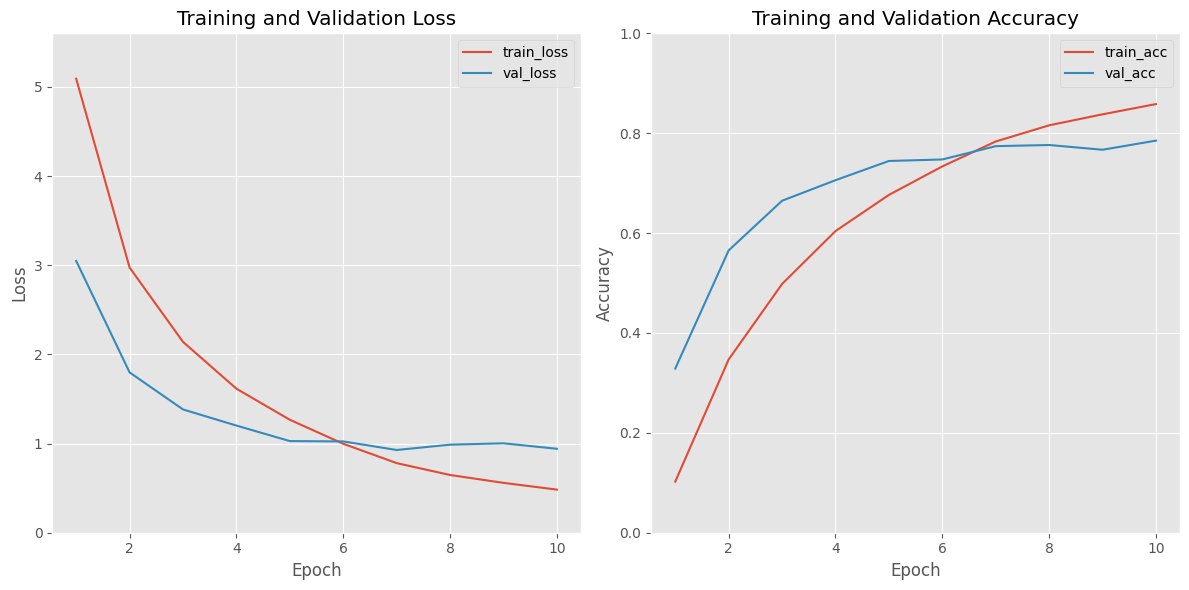

In [ ]:
plot_model_loss_acc(hist_v1)

In [ ]:
# Guardamos el modelo
model_v1.save(BASE_FOLDER+'model_v1.keras')

In [ ]:
# Cargamos el modelo y realizamos la predicción sobre el conjunto de test
model_v1 = keras.models.load_model(BASE_FOLDER+'model_v1.keras')

result = model_v1.evaluate(test_ds)
print("Test loss, test accuracy:", result)

83/83 [==============================] - 4s 28ms/step - loss: 0.7970 - accuracy: 0.8088
Test loss, test accuracy: [0.7969946265220642, 0.8087618947029114]


**Resumen de los Resultados de Entrenamiento de la Red "From Scratch"**

- **Conjuntos de Datos**: Se utilizaron conjuntos de datos que contienen imágenes pertenecientes a 525 clases diferentes.

- **Resultados de Entrenamiento**:

    - **Epochs**: Se realizaron 10 épocas de entrenamiento.
    
    - **Loss (Pérdida)**: Durante el entrenamiento, la pérdida inicial fue de aproximadamente 5.09 y disminuyó progresivamente con cada época. Al final de las 10 épocas, la pérdida se redujo significativamente a alrededor de 0.4835 en el conjunto de entrenamiento.
    
    - **Accuracy (Precisión)**: La precisión inicial fue de aproximadamente 0.1023 y aumentó gradualmente con cada época. Al final del entrenamiento, la precisión alcanzó aproximadamente 0.8584 en el conjunto de entrenamiento.
    
    - **Validation Loss (Pérdida de Validación)**: Durante el entrenamiento, la pérdida en el conjunto de validación comenzó en alrededor de 3.0483 y disminuyó consistentemente con cada época. Al final de las 10 épocas, la pérdida de validación fue de aproximadamente 0.9416.
    
    - **Validation Accuracy (Precisión de Validación)**: La precisión en el conjunto de validación también mejoró progresivamente con cada época, comenzando alrededor de 0.3288 y alcanzando aproximadamente 0.7851 al final del entrenamiento.
  
- **Resultados de Evaluación**:    
    - **Accuracy (Precisión)**: La precisión sobre el conjunto de test es de un 0.8087, valor que se encuentra en el rango de las precisiones de entrenamiento y validación.

En resumen, el entrenamiento "from scratch" de la red neuronal resultó en una mejora significativa en términos de pérdida y precisión tanto en el conjunto de entrenamiento como en el de validación a lo largo de las 10 épocas. Esto demuestra que el modelo pudo aprender efectivamente a partir de cero para clasificar las imágenes en las clases específicas del conjunto de datos, lo que se ha verificado a través de la precisión en el conjunto de entrenamiento.

# Redes Pre-Entrenadas

---
**Preparación de Datos para Transfer Learning y Fine-Tuning**

En esta sección del código se preparan los datos para el trasnsfer learning y el fine-tuning de tres redes pre-entrenadas distintas. El trasnsfer learning implica utilizar un modelo pre-entrenado como punto de partida y adaptarlo a un nuevo conjunto de datos, mientras que el fine-tuning implica ajustar aún más los pesos del modelo en el nuevo conjunto de datos para una tarea específica.

- **Preprocesamiento de Imágenes:**
  - Se utiliza `ImageDataGenerator` para realizar el preprocesamiento de las imágenes. En este caso, se aplica un reescalado de 1./255 para normalizar los valores de píxeles en el rango [0,1].

- **Carga de Datos:**
  - Se cargan los datos de entrenamiento, prueba y validación desde los directorios utilizando `flow_from_directory` de `ImageDataGenerator`.
  - Se especifica un tamaño de lote de 32 (`batch_size`) y un tamaño de imagen objetivo de 224x224 (`target_size`).
  - El parámetro `class_mode` se establece en "categorical" para indicar que se están utilizando etiquetas categóricas para la clasificación.

- **Directorios de Datos:**
  - `train_path`: Directorio que contiene las imágenes de entrenamiento.
  - `test_path`: Directorio que contiene las imágenes de prueba.
  - `val_path`: Directorio que contiene las imágenes de validación.

Estos pasos preparan los datos necesarios para realizar el trasnsfer learning y el fine-tuning de las redes en un nuevo conjunto de datos, lo que permite adaptar los modelos a una tarea específica mientras se aprovechan los conocimientos aprendidos en tareas anteriores.

---

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(directory = train_path,batch_size= 32,target_size= (224,224),class_mode = "categorical")
test_data = test_datagen.flow_from_directory(directory = test_path,batch_size = 32,target_size = (224,224),class_mode = "categorical")
val_data = valid_datagen.flow_from_directory(directory = val_path,batch_size = 32,target_size = (224,224),class_mode = "categorical")

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


# TRANSFER-LEARNING

---
### Transfer Learning con MobileNetV2

En esta sección del código, se realiza el proceso de transfer learning utilizando MobileNetV2 como base pre-entrenada.

- **Carga del Modelo Pre-Entrenado:**
  - Se carga MobileNetV2 utilizando la función `MobileNetV2` de Keras.
  - `include_top` se establece en False para excluir la capa de clasificación totalmente conectada en la parte superior del modelo, ya que se utilizará una capa personalizada para la clasificación específica del nuevo conjunto de datos.
  - `weights` se establece en 'imagenet' para cargar los pesos pre-entrenados en el conjunto de datos ImageNet.
  - `input_shape` se especifica como (224, 224, 3), que es el tamaño estándar para MobileNetV2.

- **Congelación de Capas:**
  - Se itera sobre todas las capas del modelo pre-entrenado (`base_model`) y se establece el atributo `trainable` en False para cada una de ellas. Esto congela los pesos de todas las capas del modelo pre-entrenado, lo que significa que no se actualizarán durante el entrenamiento.

- **Definición del Modelo de Transfer Learning:**
  - Se crea un modelo secuencial (`Sequential`) para organizar las capas en una secuencia lineal.
  - Se añade MobileNetV2 (`base_model`) como la primera capa del modelo.
  - Se añade una capa de aplanamiento (`Flatten`) para convertir los mapas de características 2D en un vector 1D antes de pasarlos a las capas densas.
  - Se añaden dos capas densas (`Dense`) para la clasificación final.
  - Entre las capas densas, se añade una capa de dropout (`Dropout`) con una tasa de 0.5 para prevenir el sobreajuste.

- **Compilación del Modelo:**
  - Se compila el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001.
  - Se utiliza la función de pérdida de entropía cruzada categórica (`categorical_crossentropy`), adecuada para problemas de clasificación con múltiples clases.
  - Se monitorea la precisión (`accuracy`) como métrica durante el entrenamiento.

Este proceso de transfer learning utiliza MobileNetV2 como base pre-entrenada para extraer características generales de las imágenes, y luego se añaden capas densas personalizadas para la clasificación específica del nuevo conjunto de datos.

---

In [ ]:
base_model = MobileNetV2(include_top = False,weights = 'imagenet',input_shape = (224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(525, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               32113152  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 525)               269325    
                                                                 
Total params: 34640461 (132.14 MB)
Trainable params: 32382477 (123.53 MB)
Non-trainable params: 2257984 (8.61 MB)
______

---
**Entrenamiento del Modelo de Transfer Learning**

En esta sección del código, se lleva a cabo el entrenamiento del modelo de transfer learning utilizando los conjuntos de datos de entrenamiento y validación.

- **Entrenamiento del Modelo:**
  - Se utiliza el método `fit` del modelo para entrenar el modelo de transfer learning.
  - Se especifica el conjunto de datos de entrenamiento (`train_data`) como entrada, junto con el número de épocas (`epochs`) que el modelo será entrenado.
  - Se proporciona el conjunto de datos de validación (`val_data`) para monitorear el rendimiento del modelo durante el entrenamiento.

Este paso de entrenamiento ajusta los pesos del modelo de transfer learning en función de los datos de entrenamiento y valida su desempeño utilizando los datos de validación. Durante el proceso, se monitorean las métricas de pérdida y precisión en ambos conjuntos de datos para evaluar el rendimiento del modelo.

---

In [ ]:
histo = model.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
2645/2645 [==============================] - 193s 72ms/step - loss: 4.1647 - accuracy: 0.2207 - val_loss: 1.4752 - val_accuracy: 0.6670
Epoch 2/10
2645/2645 [==============================] - 164s 62ms/step - loss: 2.0542 - accuracy: 0.5264 - val_loss: 0.8902 - val_accuracy: 0.7817
Epoch 3/10
2645/2645 [==============================] - 169s 64ms/step - loss: 1.3879 - accuracy: 0.6525 - val_loss: 0.7327 - val_accuracy: 0.8030
Epoch 4/10
2645/2645 [==============================] - 173s 65ms/step - loss: 1.0433 - accuracy: 0.7272 - val_loss: 0.6878 - val_accuracy: 0.8149
Epoch 5/10
2645/2645 [==============================] - 168s 63ms/step - loss: 0.8225 - accuracy: 0.7741 - val_loss: 0.6443 - val_accuracy: 0.8324
Epoch 6/10
2645/2645 [==============================] - 163s 62ms/step - loss: 0.6799 - accuracy: 0.8108 - val_loss: 0.6168 - val_accuracy: 0.8472
Epoch 7/10
2645/2645 [==============================] - 161s 61ms/step - loss: 0.5765 - accuracy: 0.8360 - val_loss: 0

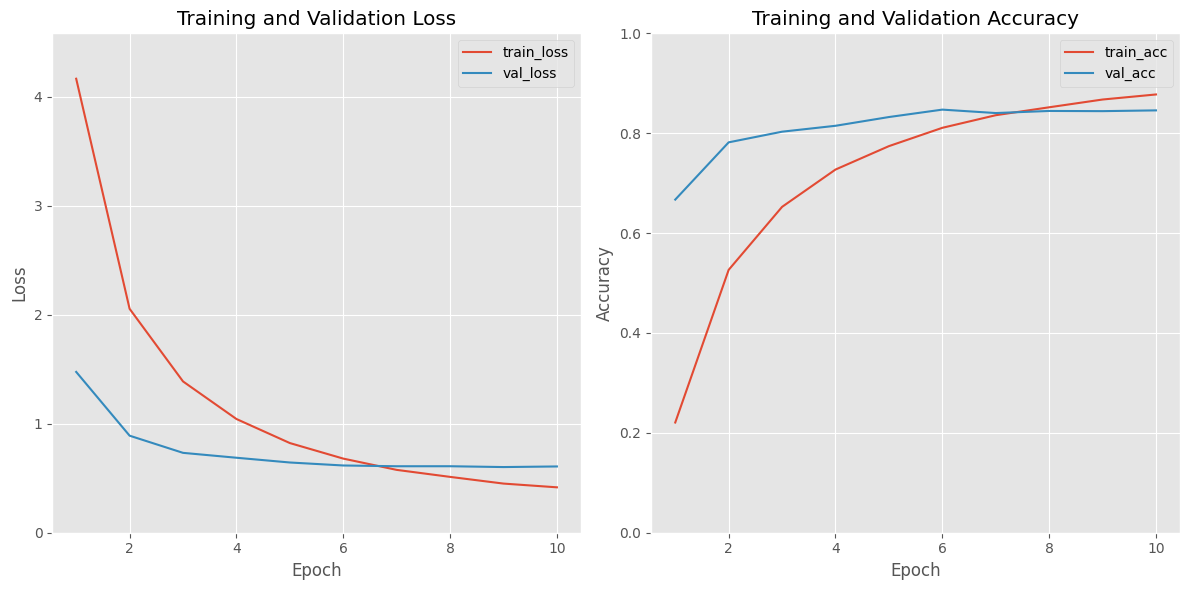

In [ ]:
plot_model_loss_acc(histo)

In [ ]:
# Guardamos el modelo
model.save(BASE_FOLDER+'model_MobileNet_TransferLearning.keras')

In [ ]:
# Cargamos el modelo y realizamos la predicción sobre el conjunto de test
model = keras.models.load_model(BASE_FOLDER+'model_MobileNet_TransferLearning.keras')

result = model.evaluate(test_data)
print("Test loss, test accuracy:", result)

83/83 [==============================] - 7s 58ms/step - loss: 0.5082 - accuracy: 0.8678
Test loss, test accuracy: [0.5081542134284973, 0.867809534072876]


**Resumen de los Resultados del Transfer Learning con MobileNetV2**

- **Epochs**: Se realizaron 10 épocas de entrenamiento.

- **Loss (Pérdida)**: Durante el entrenamiento, la pérdida inicial fue de aproximadamente 4.1647 y disminuyó progresivamente con cada época. Al final de las 10 épocas, la pérdida se redujo significativamente a alrededor de 0.4165 en el conjunto de entrenamiento.

- **Accuracy (Precisión)**: La precisión inicial fue de aproximadamente 0.2207 y aumentó gradualmente con cada época. Al final del entrenamiento, la precisión alcanzó aproximadamente 0.8776 en el conjunto de entrenamiento.

- **Validation Loss (Pérdida de Validación)**: Durante el entrenamiento, la pérdida en el conjunto de validación comenzó en alrededor de 1.4752 y disminuyó consistentemente con cada época. Al final de las 10 épocas, la pérdida de validación fue de aproximadamente 0.6079.

- **Validation Accuracy (Precisión de Validación)**: La precisión en el conjunto de validación también mejoró progresivamente con cada época, comenzando alrededor de 0.6670 y alcanzando aproximadamente 0.8457 al final del entrenamiento.

En resumen, el modelo experimentó una mejora significativa en términos de pérdida y precisión tanto en el conjunto de entrenamiento como en el de validación a lo largo de las 10 épocas. Esto sugiere que el proceso de transfer learning fue efectivo para adaptar el modelo pre-entrenado a la nueva tarea de clasificación, logrando una alta precisión en la predicción de las clases del conjunto de datos de validación.

---
### Transfer Learning con RESNet50V2


A continuación, repetiremos el procedimiento pero utilizando el modelo preentrenado con arquitecturea RESNet50V2. A diferencia de la anterior arquitectura, está es mucho más grande,contando con 25.6 millones de parámetros.

In [ ]:
# Definicion de hiperparametros
batch_size=128
learning_rate=0.0001
epochs=50
num_clases=len(os.listdir('birds_dataset/train/'))

# Cargar arquitectura y pesos: quitamos el top model para ajustarlo a nuestra tarea.
base_model = keras.applications.ResNet50V2(include_top = False,weights='imagenet',input_shape = (224,224,3))
base_model.trainable = False

inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
outputs= Dense(num_clases, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 525)               1075725   
                                                                 
Total params: 24640525 (94.00 MB)
Trainable params: 1075725 (4.10 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
H = model.fit(train_data,
              epochs=epochs,
              steps_per_epoch=train_data.n // batch_size,
              callbacks = [earlystop],
              validation_data=val_data)

Epoch 1/50
661/661 [==============================] - 59s 79ms/step - loss: 4.8110 - accuracy: 0.1790 - val_loss: 3.4215 - val_accuracy: 0.4453
Epoch 2/50
661/661 [==============================] - 56s 85ms/step - loss: 2.7839 - accuracy: 0.5498 - val_loss: 2.2102 - val_accuracy: 0.6827
Epoch 3/50
661/661 [==============================] - 58s 87ms/step - loss: 1.9400 - accuracy: 0.6993 - val_loss: 1.6264 - val_accuracy: 0.7547
Epoch 4/50
661/661 [==============================] - 53s 80ms/step - loss: 1.5011 - accuracy: 0.7606 - val_loss: 1.2988 - val_accuracy: 0.8034
Epoch 5/50
661/661 [==============================] - 51s 77ms/step - loss: 1.2404 - accuracy: 0.7972 - val_loss: 1.0930 - val_accuracy: 0.8244
Epoch 6/50
661/661 [==============================] - 49s 74ms/step - loss: 1.0460 - accuracy: 0.8226 - val_loss: 0.9491 - val_accuracy: 0.8427
Epoch 7/50
661/661 [==============================] - 50s 75ms/step - loss: 0.9431 - accuracy: 0.8344 - val_loss: 0.8487 - val_accuracy:

In [ ]:
model.save('model_RESNET.keras')

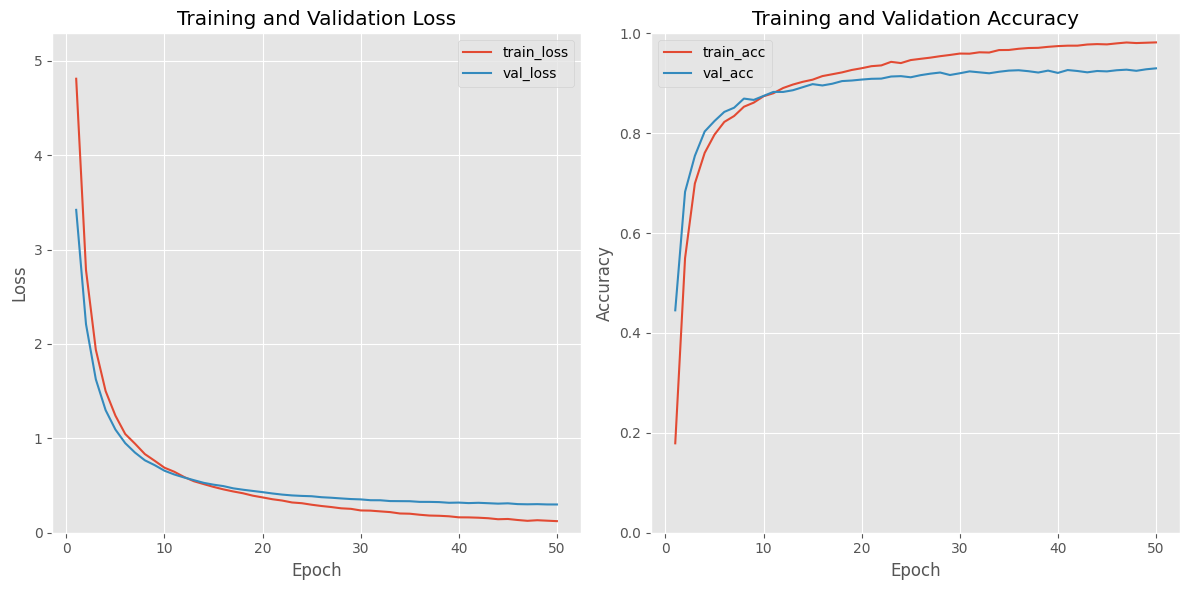

In [ ]:
plot_model_loss_acc(H)

In [ ]:
average_loss, average_accuracy = evaluate_entire_dataset(model, test_data)

print(f"Average Loss: {average_loss:.4f}")
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Average Loss: 0.2366
Average Accuracy: 93.90%


**Resumen de los Resultados del Transfer Learning con RESNet50V2**

- **Epochs**: En total, se realizaron 50 ciclos de entrenamiento.

- **Loss (Pérdida)**: La pérdida en el conjunto de entrenamiento llego a alcanzar valores cercanos al 0.12.

- **Accuracy (Precisión)**: La precisión en el conjunto de datos de entrenamiento llegó a alcanzar un 98%. Una precisión muy alta que puede ser señal de sobreentreno, pero como veremos a continuación, no ha afectado a la capacidad de generalización.

- **Validation Loss (Pérdida de Validación)**: La pérdida en el conjunto de datos de entrenamiento ha sido cercana a 0.3.

- **Validation Accuracy (Precisión de Validación)**: La precisión en el conjunto de validación alcanzó valores cercanos al 93%. Por otra parte, en el conjunto de datos de test se alcanzaron valores cercanos al 94%.

Como podemos ver, esta arquitectura parece obtener bastante buenos resultados. Podemos ver que la capacidad de generalización del modelo es bastante buena, aunque quizás con un conjunto de datos de test con más imágenes, quizás los resultados no hayan sido tan buenos.

### Transfer learning con Xception
Finalmente, vamos a repetir el proceso con la red Xception, con un tamaño algo menor que la ResNet (20.8 millones de parametros)

In [ ]:
# Definicion de hiperparametros
batch_size=128
learning_rate=0.0001
epochs=50
num_clases=len(os.listdir('birds_dataset/train/'))

# Cargar arquitectura y pesos: quitamos el top model para ajustarlo a nuestra tarea.
base_model = Xception(weights="imagenet",
                   include_top=False,
                   input_shape=(224, 224, 3))

# No entrenamos el base model
base_model.trainable = False

# Conectar el modelo con el top model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_clases, activation="softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_19 (Dense)            (None, 525)               1075725   
                                                                 
Total params: 21937205 (83.68 MB)
Trainable params: 1075725 (4.10 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [ ]:
# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenamos el top model
print("[INFO]: Entrenando la red neuronal...")
H = model.fit(train_data,
                    epochs=epochs,
                    steps_per_epoch=train_data.n // batch_size,
                    callbacks = [earlystop],
                    validation_data=val_data)

[INFO]: Entrenando la red neuronal...
Epoch 1/50
661/661 [==============================] - 55s 79ms/step - loss: 4.8876 - accuracy: 0.2176 - val_loss: 3.7199 - val_accuracy: 0.4362
Epoch 2/50
661/661 [==============================] - 53s 81ms/step - loss: 3.1945 - accuracy: 0.5027 - val_loss: 2.6422 - val_accuracy: 0.6099
Epoch 3/50
661/661 [==============================] - 51s 78ms/step - loss: 2.4412 - accuracy: 0.6223 - val_loss: 2.0757 - val_accuracy: 0.6968
Epoch 4/50
661/661 [==============================] - 56s 85ms/step - loss: 2.0091 - accuracy: 0.6900 - val_loss: 1.7235 - val_accuracy: 0.7383
Epoch 5/50
661/661 [==============================] - 54s 82ms/step - loss: 1.7097 - accuracy: 0.7246 - val_loss: 1.4805 - val_accuracy: 0.7756
Epoch 6/50
661/661 [==============================] - 53s 80ms/step - loss: 1.5085 - accuracy: 0.7488 - val_loss: 1.3091 - val_accuracy: 0.7966
Epoch 7/50
661/661 [==============================] - 51s 76ms/step - loss: 1.3711 - accuracy: 0.7

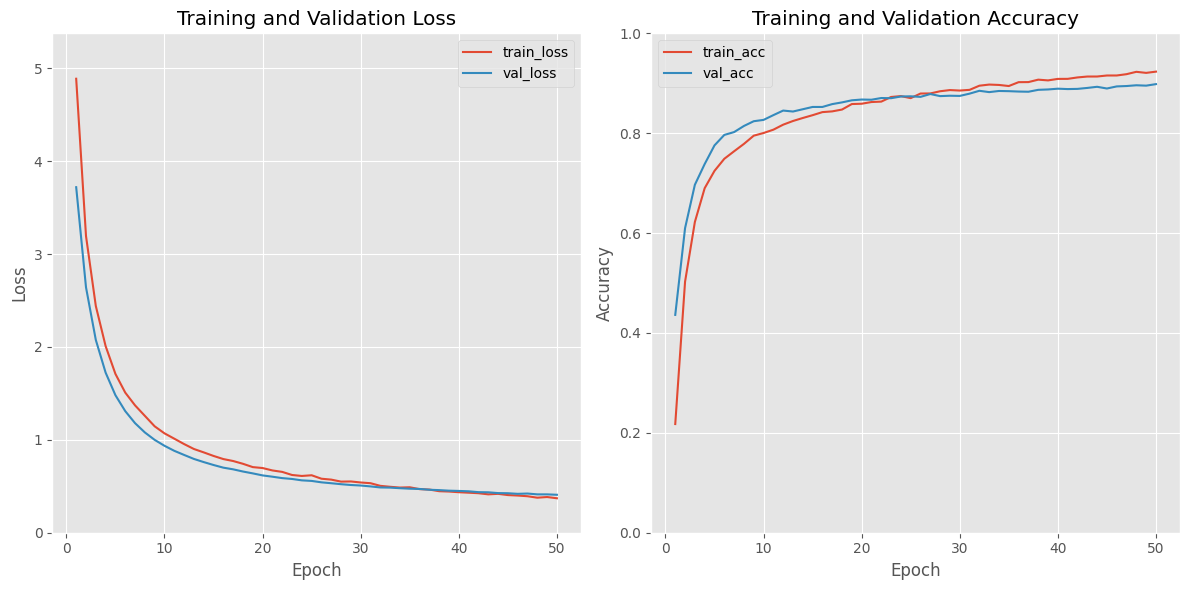

In [ ]:
plot_model_loss_acc(H)

In [ ]:
# Guardamos el modelo
model.save(BASE_FOLDER+'model_Xception_TransferLearning.keras')

In [ ]:
# Cargamos el modelo y realizamos la predicción sobre el conjunto de test
model = keras.models.load_model(BASE_FOLDER+'model_Xception_TransferLearning.keras')

result = model.evaluate(test_data)
print("Test loss, test accuracy:", result)

83/83 [==============================] - 7s 64ms/step - loss: 0.3548 - accuracy: 0.9162
Test loss, test accuracy: [0.35476845502853394, 0.916190505027771]


**Resumen de los Resultados del Transfer Learning con Xception**

- **Epochs**: En total, se realizaron 50 ciclos de entrenamiento.

- **Loss (Pérdida)**: La pérdida en el conjunto de entrenamiento llego a alcanzar valores cercanos al 0.37.

- **Accuracy (Precisión)**: La precisión en el conjunto de datos de entrenamiento llegó a alcanzar un 92%.

- **Validation Loss (Pérdida de Validación)**: La pérdida en el conjunto de datos de entrenamiento ha sido cercana a 0.4.

- **Validation Accuracy (Precisión de Validación)**: La precisión en el conjunto de validación alcanzó valores cercanos al 89%, algo por debajo e la precisión en entrenamiento como era de esperar. Por otra parte, en el conjunto de datos de test se alcanzaron valores cercanos del 91.6%, lo cual indica que el entrenamiento del modelo ha sido bueno y no ha producido sobreajuste.

Como podemos ver, esta arquitectura ha obtenido buenos resultados en clasificación y es capaz de generalizar para nuevos datos.

# FINE-TUNING

---
### **Fine-Tuning con MobileNetV2**

En esta sección del código, se lleva a cabo el fine-tuning de MobileNetV2, una red neuronal convolucional pre-entrenada, en un nuevo conjunto de datos. El fine-tuning implica ajustar los pesos de las capas superiores del modelo pre-entrenado en el nuevo conjunto de datos específico.

- **Carga de MobileNetV2 Pre-Entrenada:**
  - Se carga la arquitectura MobileNetV2 pre-entrenada utilizando la función `MobileNetV2` de Keras.
  - `include_top` se establece en False para cargar el modelo sin la capa de clasificación totalmente conectada, ya que se utilizará una capa personalizada para la clasificación del nuevo conjunto de datos.
  - `weights` se establece en 'imagenet' para cargar los pesos pre-entrenados en el conjunto de datos ImageNet, que servirán como punto de partida para el fine-tuning.
  - `input_shape` se especifica como (224, 224, 3), que es el tamaño estándar para MobileNetV2.

MobileNetV2 se utiliza como base para transferir su conocimiento previo sobre características generales de las imágenes al nuevo conjunto de datos. Luego, se ajustan los pesos de las capas superiores durante el fine-tuning para adaptarse mejor al nuevo dominio de imágenes y a la tarea específica.

---

In [ ]:
base_model = MobileNetV2(include_top = False,weights = 'imagenet',input_shape = (224,224,3))

9406464/9406464 [==============================] - 1s 0us/step


---
**Congelación de Capas en el Proceso de Fine-Tuning**

En esta sección del código, se congela la primera tercera parte de las capas de la red pre-entrenada (MobileNetV2) durante el proceso de fine-tuning. Congelar las capas significa que sus pesos no se actualizarán durante el entrenamiento, lo que permite preservar los conocimientos aprendidos en tareas anteriores y enfocar el proceso de ajuste en las capas más específicas para la nueva tarea.

- **Iteración sobre Capas:**
  - Se itera sobre todas las capas de la red pre-entrenada `base_model`.
  - Se congela la primera tercera parte de las capas, estableciendo el atributo `trainable` en False para estas capas.

Esta estrategia de congelación se utiliza para controlar qué partes de la red pre-entrenada se ajustarán durante el proceso de fine-tuning. Al congelar las capas menos específicas en la primera parte de la red, se evita que se modifiquen demasiado y se conserva la capacidad de la red para extraer características generales de las imágenes.

---

In [ ]:
for layer in base_model.layers[:len(base_model.layers)//3]:
  layer.trainable = False

  ---
**Definición y Compilación del Modelo de Fine-Tuning con MobileNetV2**

En esta sección del código, se define y compila el modelo para llevar a cabo el fine-tuning utilizando MobileNetV2 como base pre-entrenada.

- **Definición del Modelo:**
  - Se crea un modelo secuencial (`Sequential`) para organizar las capas en una secuencia lineal.
  - Se añade MobileNetV2 (`base_model`) como la primera capa del modelo, aprovechando su capacidad para extraer características de las imágenes.
  - Se añade una capa de aplanamiento (`Flatten`) para convertir los mapas de características 2D en un vector 1D antes de pasarlos a las capas densas.
  - Se añaden dos capas densas (`Dense`) para la clasificación final.
  - Entre las capas densas, se añade una capa de dropout (`Dropout`) con una tasa de 0.5 para prevenir el sobreajuste.

- **Compilación del Modelo:**
  - Se compila el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001.
  - Se utiliza la función de pérdida de entropía cruzada categórica (`categorical_crossentropy`), adecuada para problemas de clasificación con múltiples clases.
  - Se monitorea la precisión (`accuracy`) como métrica durante el entrenamiento.

Este modelo define la arquitectura para el proceso de fine-tuning, donde MobileNetV2 se utiliza como base pre-entrenada para la extracción de características, seguida de capas densas personalizadas para la clasificación específica del nuevo conjunto de datos. Durante el proceso de compilación, se configuran el optimizador y la función de pérdida para el entrenamiento del modelo.

---

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(525, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_13 (Dense)            (None, 512)               32113152  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 525)               269325    
                                                                 
Total params: 34640461 (132.14 MB)
Trainable params: 34557069 (131.82 MB)
Non-trainable params: 83392 (325.75 KB)
______

---
**Entrenamiento del Modelo de Fine-Tuning**

En esta sección del código, se lleva a cabo el entrenamiento del modelo de fine-tuning utilizando los conjuntos de datos de entrenamiento y validación.

- **Entrenamiento del Modelo:**
  - Se utiliza el método `fit` del modelo para entrenar el modelo de fine-tuning.
  - Se especifica el conjunto de datos de entrenamiento (`train_data`) como entrada, junto con el número de épocas (`epochs`) que el modelo será entrenado.
  - Se proporciona el conjunto de datos de validación (`val_data`) para monitorear el rendimiento del modelo durante el entrenamiento.

Este paso de entrenamiento ajusta los pesos del modelo de fine-tuning en función de los datos de entrenamiento y valida su desempeño utilizando los datos de validación. Durante el proceso, se monitorean las métricas de pérdida y precisión en ambos conjuntos de datos para evaluar el rendimiento del modelo.

---

In [ ]:
history = model.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
2645/2645 [==============================] - 290s 102ms/step - loss: 3.6237 - accuracy: 0.3175 - val_loss: 0.6972 - val_accuracy: 0.8229
Epoch 2/10
2645/2645 [==============================] - 190s 72ms/step - loss: 1.0746 - accuracy: 0.7410 - val_loss: 0.3457 - val_accuracy: 0.9051
Epoch 3/10
2645/2645 [==============================] - 196s 74ms/step - loss: 0.5949 - accuracy: 0.8478 - val_loss: 0.2770 - val_accuracy: 0.9250
Epoch 4/10
2645/2645 [==============================] - 188s 71ms/step - loss: 0.4049 - accuracy: 0.8900 - val_loss: 0.2727 - val_accuracy: 0.9284
Epoch 5/10
2645/2645 [==============================] - 210s 79ms/step - loss: 0.3003 - accuracy: 0.9168 - val_loss: 0.2537 - val_accuracy: 0.9345
Epoch 6/10
2645/2645 [==============================] - 193s 73ms/step - loss: 0.2396 - accuracy: 0.9319 - val_loss: 0.2371 - val_accuracy: 0.9410
Epoch 7/10
2645/2645 [==============================] - 191s 72ms/step - loss: 0.2008 - accuracy: 0.9421 - val_loss: 

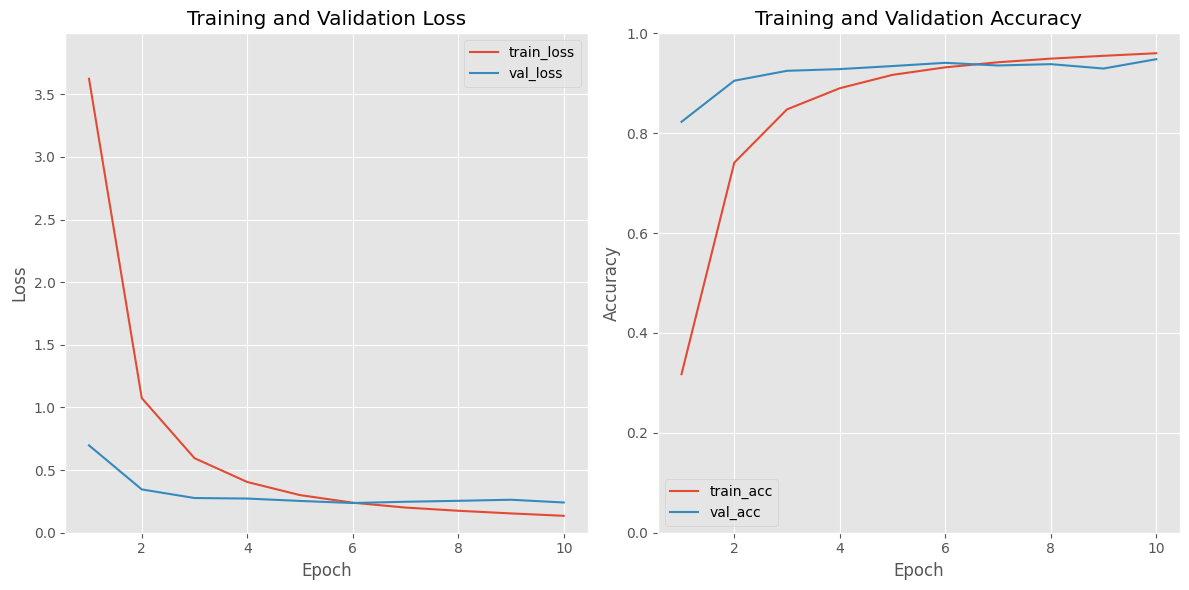

In [ ]:
plot_model_loss_acc(history)

In [ ]:
# Guardamos el modelo
model.save(BASE_FOLDER+'model_MobileNet_FineTuning.keras')

In [ ]:
# Cargamos el modelo y realizamos la predicción sobre el conjunto de test
model = keras.models.load_model(BASE_FOLDER+'model_MobileNet_FineTuning.keras')

average_loss, average_accuracy = evaluate_entire_dataset(model, test_data)
print(f"Average Loss: {average_loss:.4f}")
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Average Loss: 0.1191
Average Accuracy: 96.65%


**Resumen de los Resultados del Fine-Tuning**

- **Epochs**: Se realizaron 10 épocas de entrenamiento.

- **Loss (Pérdida)**: Durante el entrenamiento, la pérdida inicial fue de aproximadamente 3.6237 y disminuyó progresivamente con cada época. Al final de las 10 épocas, la pérdida se redujo significativamente a alrededor de 0.1351 en el conjunto de entrenamiento.

- **Accuracy (Precisión)**: La precisión inicial fue de aproximadamente 0.3175 y aumentó gradualmente con cada época. Al final del entrenamiento, la precisión alcanzó aproximadamente 0.9602 en el conjunto de entrenamiento.

- **Validation Loss (Pérdida de Validación)**: Durante el entrenamiento, la pérdida en el conjunto de validación comenzó en alrededor de 0.6972 y disminuyó consistentemente con cada época. Al final de las 10 épocas, la pérdida de validación fue de aproximadamente 0.2412.

- **Validation Accuracy (Precisión de Validación)**: La precisión en el conjunto de validación también mejoró progresivamente con cada época, comenzando alrededor de 0.8229 y alcanzando aproximadamente 0.9482 al final del entrenamiento.

En resumen, el proceso de fine-tuning resultó en una mejora significativa en términos de pérdida y precisión tanto en el conjunto de entrenamiento como en el de validación a lo largo de las 10 épocas. Esto demuestra que ajustar las capas finales del modelo pre-entrenado para adaptarse al nuevo conjunto de datos produjo un modelo más preciso y generalizable para la tarea de clasificación de imágenes.

### **Fine tuning con RESNet50V2**

Por último, vamos a repetir el proceso para la red RESNet50V2. Como base, utilizaremos el modelo que hemos entrenado utilizando transfer learning e intentaremos mejorarlo volviendo a entrenar el 66% de las capas más cercanas al top model.<br/>
En este caso, se ha utilizado un learning rate algo menor para evitar modificar mucho las representaciones de las capas que estamos modificando.


In [ ]:
model = keras.models.load_model('model_RESNET.keras')
base_model = model.get_layer('resnet50v2')
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers)//3]:
  layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(train_data,
              epochs=30,
              steps_per_epoch=train_data.n // batch_size,
              callbacks = [earlystop],
              validation_data=val_data)

Epoch 1/30
661/661 [==============================] - 90s 103ms/step - loss: 0.5420 - accuracy: 0.8708 - val_loss: 0.3635 - val_accuracy: 0.9082
Epoch 2/30
661/661 [==============================] - 66s 100ms/step - loss: 0.2431 - accuracy: 0.9498 - val_loss: 0.2947 - val_accuracy: 0.9223
Epoch 3/30
661/661 [==============================] - 69s 104ms/step - loss: 0.1770 - accuracy: 0.9647 - val_loss: 0.2581 - val_accuracy: 0.9360
Epoch 4/30
661/661 [==============================] - 69s 104ms/step - loss: 0.1455 - accuracy: 0.9714 - val_loss: 0.2375 - val_accuracy: 0.9421
Epoch 5/30
661/661 [==============================] - 69s 105ms/step - loss: 0.1110 - accuracy: 0.9798 - val_loss: 0.2290 - val_accuracy: 0.9375
Epoch 6/30
661/661 [==============================] - 68s 103ms/step - loss: 0.0916 - accuracy: 0.9848 - val_loss: 0.2190 - val_accuracy: 0.9406
Epoch 7/30
661/661 [==============================] - 71s 107ms/step - loss: 0.0774 - accuracy: 0.9873 - val_loss: 0.2123 - val_ac

In [ ]:
model.save('model_RESNET_finetuned.keras')

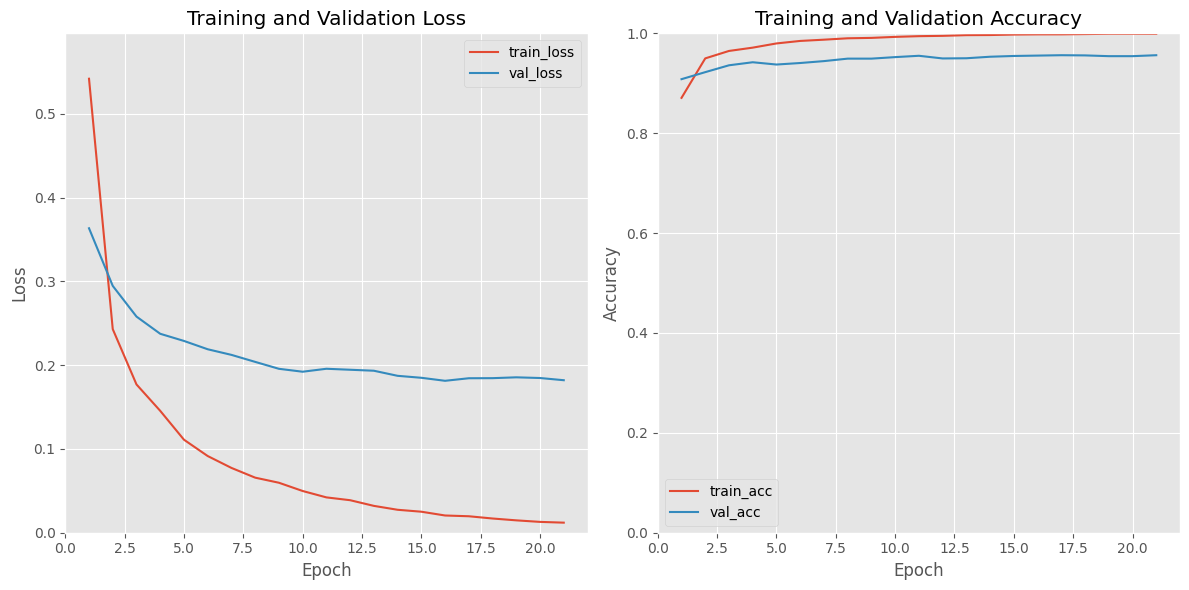

In [ ]:
plot_model_loss_acc(H)

In [ ]:
average_loss, average_accuracy = evaluate_entire_dataset(model, test_data)

print(f"Average Loss: {average_loss:.4f}")
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Average Loss: 0.1349
Average Accuracy: 96.23%


**Resumen de los Resultados del Fine-Tuning**

- **Epochs**: Originalmente se iban a realizar 30 ciclos de entrenamiento. Sin embargo, debido a que el valor de la función de pérdida no ha mejorado desde el ciclo 16, la ejecución del entrenamiento se ha detenido en el ciclo 21

- **Loss (Pérdida)**: Podemos observar que la pérdida era algo pero que en el primer entrenamiento, pero a partir del segundo ciclo, los resultados obtenidos ya eran mejores que utilizando solo transfer learning. La pérdida final ha sido de 0.012.

- **Accuracy (Precisión)**: De la misma forma que la pérdida, la precisión también aumentó a 0.999. Esto se debe principalmente al hecho de que la red ya había sido entrenada durante 50 ciclos en el apartado de transfer learning.

- **Validation Loss (Pérdida de Validación)**: La pérdida en el conjunto de datos de validación también ha mejorado, situándose ahora en un 0.18.

- **Validation Accuracy (Precisión de Validación)**: Podemos observar que tanto en el conjunto de datos de validación como en el de test, hemos obtenido una precisión cercana al 96%, mejorando así los resultados obtenidos en la etapa de transfer learning.

Utilizando transfer learning combinado con fine tuning, podemos observar que es posible alcanzar una gran precisión para los datos de nuestro problema en concreto, sin necesidad de entrenar un modelo con millones de parámetros desde cero.

### **Fine tuning con Xception**

Por último, vamos a repetir de nuevo el proceso con la red Xception, congelando también únicamente el primer tercio de las capas y reentrenando el peso de las capas restantes junto al top model.


In [ ]:
# Definicion de hiperparametros
batch_size=128
learning_rate=0.0001
epochs=50
num_clases=len(os.listdir('birds_dataset/train/'))

# Cargar arquitectura y pesos: quitamos el top model para ajustarlo a nuestra tarea.
base_model = Xception(weights="imagenet",
                   include_top=False,
                   input_shape=(224, 224, 3))

# Congelamos el primer tercio de las capas del base model
for layer in base_model.layers[:len(base_model.layers)//3]:
  layer.trainable = False

# Conectar el modelo con el top model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_clases, activation="softmax"))
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 525)               1075725   
                                                                 
Total params: 21937205 (83.68 MB)
Trainable params: 19163397 (73.10 MB)
Non-trainable params: 2773808 (10.58 MB)
_________________________________________________________________


In [ ]:
# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenamos el top model
print("[INFO]: Entrenando la red neuronal...")
H = model.fit(train_data,
                    epochs=epochs,
                    steps_per_epoch=train_data.n // batch_size,
                    callbacks = [earlystop],
                    validation_data=val_data)

[INFO]: Entrenando la red neuronal...
Epoch 1/50
661/661 [==============================] - 100s 119ms/step - loss: 3.7964 - accuracy: 0.3950 - val_loss: 1.4500 - val_accuracy: 0.7733
Epoch 2/50
661/661 [==============================] - 74s 112ms/step - loss: 1.0989 - accuracy: 0.8242 - val_loss: 0.5444 - val_accuracy: 0.9032
Epoch 3/50
661/661 [==============================] - 74s 112ms/step - loss: 0.5100 - accuracy: 0.9080 - val_loss: 0.3166 - val_accuracy: 0.9310
Epoch 4/50
661/661 [==============================] - 74s 112ms/step - loss: 0.3361 - accuracy: 0.9331 - val_loss: 0.2464 - val_accuracy: 0.9463
Epoch 5/50
661/661 [==============================] - 74s 111ms/step - loss: 0.2465 - accuracy: 0.9498 - val_loss: 0.1926 - val_accuracy: 0.9524
Epoch 6/50
661/661 [==============================] - 74s 112ms/step - loss: 0.1816 - accuracy: 0.9626 - val_loss: 0.1696 - val_accuracy: 0.9585
Epoch 7/50
661/661 [==============================] - 73s 111ms/step - loss: 0.1423 - accur

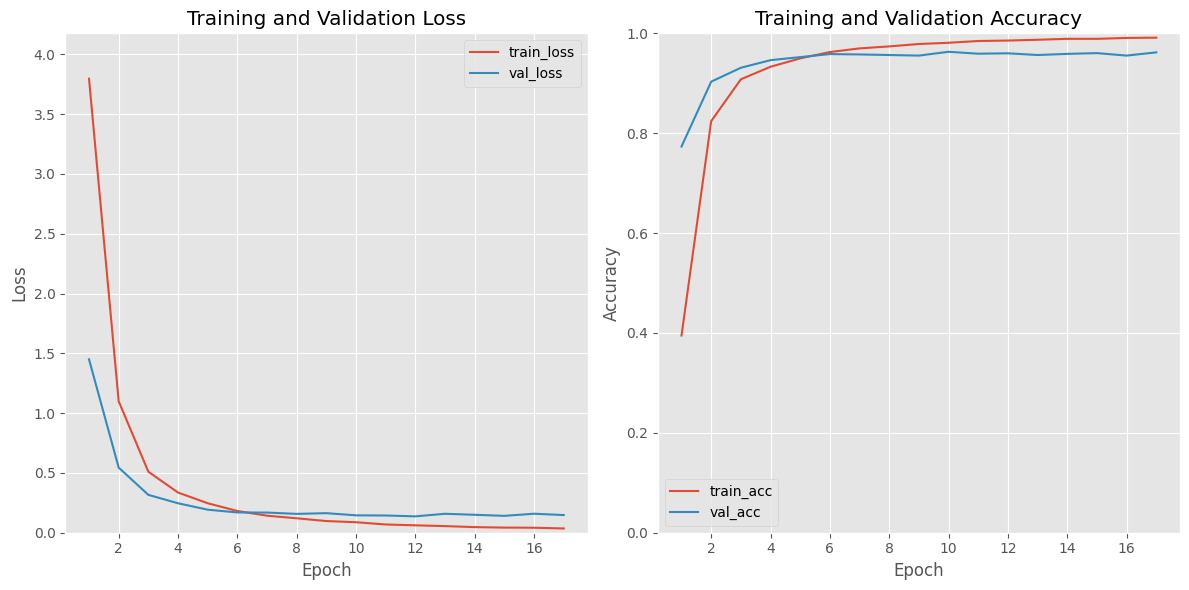

In [ ]:
plot_model_loss_acc(H)

In [ ]:
# Guardamos el modelo
model.save(BASE_FOLDER+'model_Xception_FineTuning.keras')

In [ ]:
# Cargamos el modelo y realizamos la predicción sobre el conjunto de test
model = keras.models.load_model(BASE_FOLDER+'model_Xception_FineTuning.keras')

result = model.evaluate(test_data)
print("Test loss, test accuracy:", result)

83/83 [==============================] - 7s 73ms/step - loss: 0.0855 - accuracy: 0.9768
Test loss, test accuracy: [0.08550699055194855, 0.9767618775367737]


**Resumen de los Resultados del Fine-Tuning**

- **Epochs**: Aunque estaba previsto realizar un entrenamiento de 50 épocas, debido al callback que comprueba si la pérdida en validación continua descendiendo únicamente se han realizado 17 épocas.

- **Loss (Pérdida)**: Podemos observar que la pérdida era algo pero que en el primer entrenamiento, pero a partir del segundo ciclo, los resultados obtenidos ya eran mejores que utilizando solo transfer learning. La pérdida final ha sido de 0.035.

- **Accuracy (Precisión)**: De la misma forma que la pérdida, la precisión también aumentó a 99.13%.

- **Validation Loss (Pérdida de Validación)**: La pérdida en el conjunto de datos de validación también ha mejorado, situándose ahora en un 0.14.

- **Validation Accuracy (Precisión de Validación)**: Podemos observar que en el conjunto de datos de validación se ha obtenido un 96.19% de precisión, mientras que en el de test se ha obtenido un 97.67%.

Observamos que a través del fine tuning, que permite entrenar un mayor número de capas manteniendo la estructura inicial de la red, se obtienen muy buenos resultados con una gran capacidad de generalización de la red.

# Comparación de las Tres Estrategias de Entrenamiento


Todas las estrategias que hemos utilizado han demostrado tener resultados favorables. La red "from scratch" ha sido con diferencia la peor de las opciones, ya que solo hemos sido capaces de obtener una precisión del 80%. Sin embargo, dependiendo del contexto, este tampoco habría sido el peor resultado, ya que comparándolo con la población general es mucho más hábil distinguiendo especies de pájaros.

Sin embargo, utilizando transfer learning hemos podido dar un paso adelante y obtener resultados mucho mejores sin aumentar la complejidad del código. En este apartado, la red que mejor se ha comportado ha sido la entrenada a partir de la arquitectura RESNet50V2, en parte por haber sido entrenada durante más épocas (MobileNetV2 solo se ha entrenado durante 10 épocas) y en parte por su mayor complejidad, haciendo que sea capaz de distinguir representaciones más complejas.

Utilizando fine tuning hemos sido capaces de mejorar más incluso el modelo, obteniendo resultados muy similares entre las 3 redes utilizadas, con el modelo con Xception obteniendo los mejores resultados con una precisión en el conjunto de datos de test del 97%.

Qué modelo utilizar dependerá en gran medida del caso de uso del problema. Si nuestro objetivo es obtener la mayor precisión posible, la mejor opción sería utilizar el modelo construido a partir de la arquitectura Xception. Sin embargo, si no es necesario obtener la mayor precisión posible y necesitamos que nuestro modelo sea ligero, utilizar el modelo construido a partir de la arquitectura MobileNetV2 sería una mejor opción.